In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

length = 5000

Use CPU


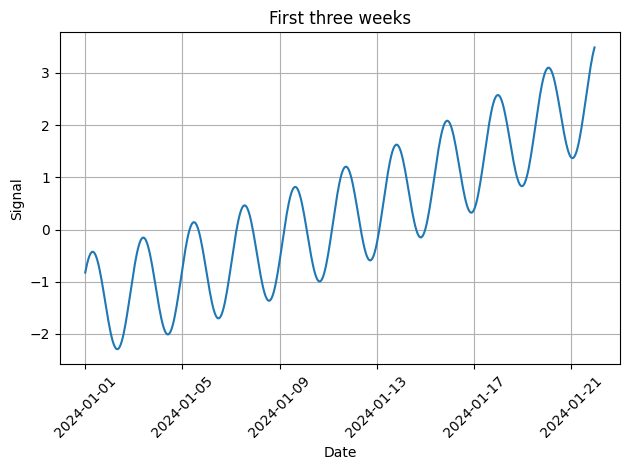

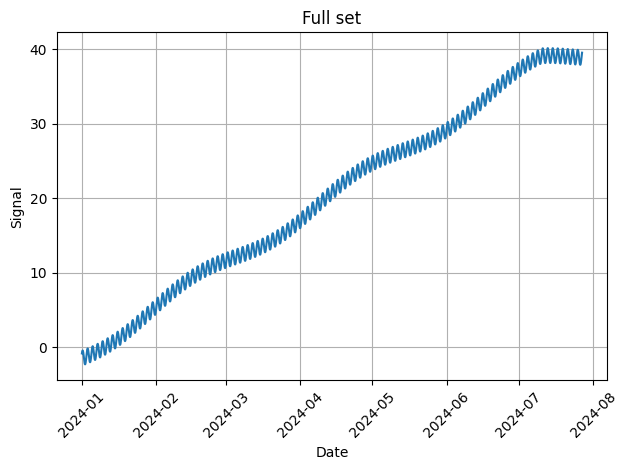

In [2]:
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0)
dp.add_sine(freq_amp=[(3/length,1), (100/length, 1)])
dp.add_trend(nbr_trends=2, slope=50/length)
dp.plot_data()

In [3]:
dp.generate_csv()

In [4]:
dp.df

,date,signal_1
0,2024-01-01 00:00:00,-0.825769
1,2024-01-01 01:00:00,-0.729061
2,2024-01-01 02:00:00,-0.643855
3,2024-01-01 03:00:00,-0.571413
4,2024-01-01 04:00:00,-0.512796
...,...,...
4995,2024-07-27 03:00:00,39.106603
4996,2024-07-27 04:00:00,39.227622
4997,2024-07-27 05:00:00,39.343762
4998,2024-07-27 06:00:00,39.453181


In [5]:
exp.train()

train 2973
val 309
test 809
Validation loss decreased (inf --> 0.002011).  Saving model ...
Updating learning rate to 5.774693366163212e-05
EarlyStopping counter: 1 out of 10
Updating learning rate to 9.397136860148879e-09
Total training time: 0.0 minutes 15.924154281616211 seconds


<All keys matched successfully>